In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import numpy as np
import os
import pandas as pd

moneybar_dtype = np.dtype([
    ("bid", np.float64),
    ("ask", np.float64),
    ("mlast", np.float64),
    ("msc", np.int64)
])

In [3]:
cd D:\Users\andre.ferreira\AppData\Roaming\MetaQuotes\Terminal\8B052D0699A0083067EBF3A36123603B\MQL5\Files

D:\Users\andre.ferreira\AppData\Roaming\MetaQuotes\Terminal\8B052D0699A0083067EBF3A36123603B\MQL5\Files


In [4]:
cd D:\MetaTrader 5\hard_link_AppDataRoamingMetaQuotes_Terminal\8B052D0699A0083067EBF3A36123603B\MQL5\Files

[WinError 3] O sistema não pode encontrar o caminho especificado: 'D:\\MetaTrader 5\\hard_link_AppDataRoamingMetaQuotes_Terminal\\8B052D0699A0083067EBF3A36123603B\\MQL5\\Files'
D:\Users\andre.ferreira\AppData\Roaming\MetaQuotes\Terminal\8B052D0699A0083067EBF3A36123603B\MQL5\Files


In [5]:
data = np.fromfile('WINV19_0.5_mbar.bin', dtype=moneybar_dtype)

In [6]:
moneybar_dtype.fields

mappingproxy({'bid': (dtype('float64'), 0),
              'ask': (dtype('float64'), 8),
              'mlast': (dtype('float64'), 16),
              'msc': (dtype('int64'), 24)})

In [7]:
dfdata = pd.DataFrame.from_records(data)

In [8]:
#dfdata.msc = dfdata.msc.astype('datetime64[ms]')

In [9]:
dfdata.head()

,bid,ask,mlast,msc
0,102535.0,102540.0,102540.0,1570205592357
1,102535.0,102540.0,102540.0,1570205592355
2,102535.0,102545.0,102540.0,1570205592354
3,102535.0,102540.0,102540.0,1570205592352
4,102535.0,102540.0,102540.0,1570205592352


In [10]:
dfdata.set_index(dfdata.msc, drop=True, inplace=True)

In [11]:
dfdata.sort_index(inplace=True)

In [12]:
dfdata.drop(columns='msc', inplace=True)

In [13]:
dfdata.head()

,bid,ask,mlast
msc,,,
1569321349387,104720.0,104725.0,104725.0
1569321349387,104720.0,104725.0,104725.0
1569321349387,104720.0,104725.0,104725.0
1569321349389,104720.0,104725.0,104725.0
1569321349389,104720.0,104725.0,104725.0


In [14]:
dfdatadata = dfdata[:200000]

### Velocity

In [15]:
velocity = dfdata.index[1:]-dfdata.index[:-1]

In [16]:
velocity = velocity.to_numpy()

In [17]:
velocity[ velocity > 60000*60*4] = 0 # 4 hours

In [18]:
velocity += 1

In [19]:
velocity = 1/velocity

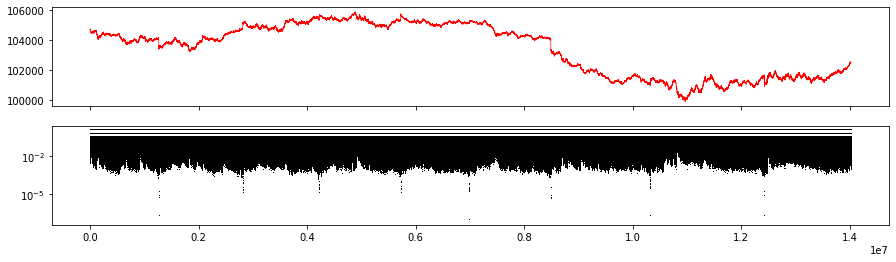

In [20]:
fig, axr = plt.subplots(2, sharex=True, figsize=(15,4))
axr[0].plot(dfdata.mlast.values[:-1], 'r', lw=0.6)
axr[1].plot(velocity, 'k,', lw=0.8)
axr[1].set_yscale('log')

In [21]:
cd D:\Users\andre.ferreira\Projects\stocks\prototypes

D:\Users\andre.ferreira\Projects\stocks\prototypes


### Fractional Diferences - Preserving Memory in Stationary Time Series

### First order derivative Fractional

Finite diferences coeficientes backward for series can be written with following formula. 
Where $n$ is the derivative order, $h$ is the discrete increment in $t$ and $k$ is the order of the schema. 

$$ \Delta^{n}_{h} f(t) = \sum_{i=0}^{n} (-1)^{i} \binom{n}{i} f\left(t-ih\right) $$

for h=1 considering f(t) as discrete time series and using the notation $ f(t) = X_t $ we can write:


$$ \Delta^{n} X_t = \sum_{i=0}^{n} (-1)^{i} \binom{n}{i} X_{t-i} $$


Considering the case where n=1 first order derivative. 

$$ \Delta^{1} X_t = \sum_{i=0}^{1} (-1)^{i} \binom{1}{i} X_{t-i} $$


$$ \binom{n}{k} = \frac{n!}{k! (n-k)!} $$

$$ i(0) = \frac{1!}{0!(1-0)!}X_{t-0} = X_t $$
$$ i(1) = \frac{1!}{1(1-1)!}X_{t-1} = -X_{t-1} $$

We get equation bellow:
$$ \Delta^{1} X_t = \sum_{i=0}^{1} (-1)^{i} \binom{1}{i} X_{t-i} = X_t -X_{t-1} $$                             

Using the notation for the lag operator $B$ defined for a time series $X_t$ as 
$ B X_t = X_{t-1} $.  Also polynomials of this operator are understood as repeated application, e.g. $B^2X_t=X_{t-2}$ . 

We can write 

$$ \Delta^1 X_t = X_t - X_{t-1} = (1-B)^1 X_t $$

BUT let's consider for while that we want the half or fractional derivative them we can expand $(1-B)^d$ using Binomial coefficients:

![title](frac_differences.png)

Those are the coeficients multiplying the time series $X_t$, $X_{t-1}$, $X_{t-2}$ etc. Like   


$$ \sum^{\infty }_{k=0} \frac{\prod^{k-1}_{a=0} (d-a)(-B)^k }{k!} $$


$$ 1X_t - dB X_t + \frac{d(d-1)}{2!}B^2X_t - ... =  X_t - dX_{t-1} + \frac{d(d-1)}{2!}X_{t-2} - ... $$







## Better original book pages

![title](frac_dif_1.png)

![title](frac_dif_2.png)

### Filter weights calculation

- for k = 0 until we desire. 
- w0 = 1
- as k goes to inf. the weights corresponds to coeficients of more negative samples

$$ \omega_{k} = -\omega_{k-1}\frac{d-k+1}{k} $$

In [22]:
from numba import jit

@jit(nopython=True)
def getWeights(d, size):    
    w = np.zeros(size)
    w[0] = 1.
    for k in range(1, size):
        w[k]=-w[k-1]/k*(d-k+1)
    return w[::-1]

In [23]:
getWeights(0.5, 10)

array([-0.01091003, -0.01309204, -0.01611328, -0.02050781, -0.02734375,
       -0.0390625 , -0.0625    , -0.125     , -0.5       ,  1.        ])

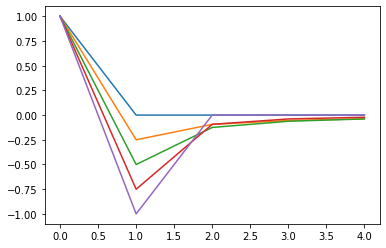

In [24]:
for d in np.linspace(0, 1, 5):
    plt.plot(getWeights(d, 5)[::-1], label=str(d))

### Testing Frac-Diff with 30k money bars

- The bigger the filter size better the stationarity achieved
- The bigger the fractional (closer to 1) better the stationarity achieved
    - but we want it to be smaller as possible to preserve as much memory as possible
- Tested differente fractional values and filter sizes
- On production better be conservative using a bigger fractional value and bigger filter size
    - Like 0.60 and ksize=512 

In [67]:
data = dfdata.mlast[:30000].values

In [68]:
ksize = 512

Generic function to get filter kernel based on desired kernel size
 - considering only cross-correlation dont need to append zero
 - if you think about a filter kernel you need to append zeros and make a convolution

In [69]:
def getKernel(ksize, d=0.45):    
    kernel = getWeights(d, ksize)
    return kernel

In [70]:
kernel = getKernel(ksize, d=0.56)

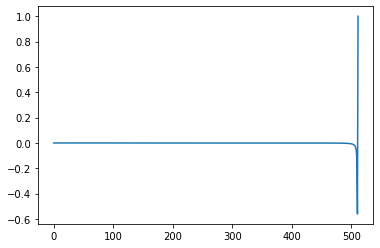

In [72]:
plt.plot(kernel)

In [73]:
np.sum(kernel)

0.015111031233626414

For the data array the first valid sample at [kernel.size-1]  
ksize-1 samples before are needed to produce the sample at 0 

- Getting only the valid samples is what we want!
 - [kernel.size-1:corrsize-kernel.size+1] 
 - is the same as mode='valid'

In [74]:
from scipy.signal import correlate as fftcorr

In [75]:
corrsize = kernel.size + data.size - 1

In [76]:
len(data), ksize, len(data)-ksize+1, corrsize-(ksize-1)*2

(30000, 512, 29489, 29489)

In [86]:
%%time
data_filter = fftcorr(data, kernel)[kernel.size-1:corrsize-kernel.size+1]
# data_filter = fftcorr(data, kernel, mode='valid')
# much faster above due fft convolve default used
#%%time
#data_filtered = np.convolve(data, kernel[::-1])[kernel.size:corrsize-ksize]

Wall time: 3 ms


### Mql5 fft correlation adaptation 
- the negative lags are in the end 

eg. 

    in = [1, 1, 2, 1, 1]  # m size 5
    ksize = 3
    filter = [1, 2, 1]  # n size 3
    corrsize = 7 # m+n-1
    expected output = [1, 3, 5, 6, 5, 3, 1]
         mql output = [5, 6, 5, 3, 1, 1, 3]
    
**We want is only the region with full overlapping with the coeficients of the filter that are nonzero.**

So the clipped output is for python:
 - [5, 6, 5] 
 - ksize-1 until full overlap with filter
 - corrsize-ksize+1 in the end
 - [ksize-1, corrsize-ksize+1] [close to the right and, open to the left < corrsize-ksize+1]
 
For mql5, starts with full overlapping
 - [0, corrsize-(ksize-1)*2] [close to the right and, open to the left < corrsize-(ksize-1)*2]

In [78]:
#inp = [1, 1, 2, 1, 1]
#pat = [1, 2, 1]
#fftcorr(inp, pat, mode='full')
#fftcorr(inp, pat, mode='valid')

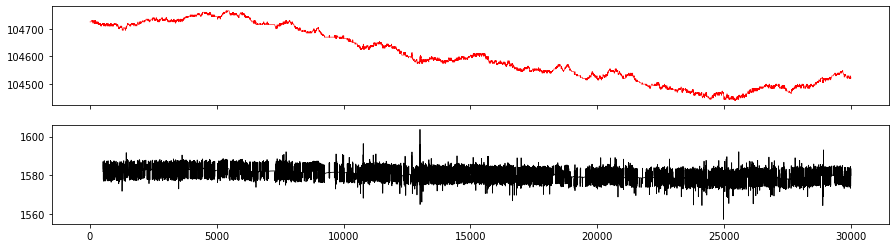

In [79]:
fig, axr = plt.subplots(2, sharex=True, figsize=(15,4))
axr[0].plot(data, 'r-', lw=0.6)
axr[1].plot(np.arange(kernel.size-1, len(data)), data_filter, 'k-', lw=0.8)

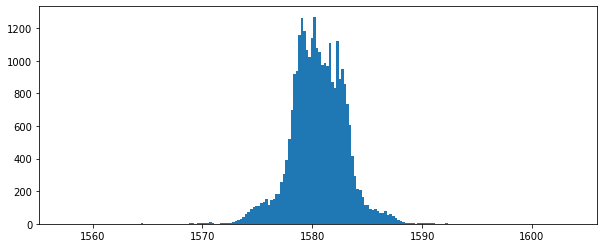

In [80]:
plt.figure(figsize=(10, 4))
plt.hist(data_filter, bins=200);

### Augmented Dickey–Fuller test

https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html

- dfuller()[1]:   
    - p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.  
    - p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.  
    
    
- dfuller()[0]:  
    - ADF Statistic - compare with critical values if smaller it is stationary 
    
 
- dfuller()[4]:  
    - 1%  - 99% confidence limit for being not stationary
    - 5%  - 95% confidence limit for being not stationary
    - 10% - 90% confidence limit for being not stationary

In [81]:
from statsmodels.tsa.stattools import adfuller

In [82]:
adfuller(data_filter)

(-6.00407374551551,
 1.631246925286447e-07,
 50,
 29438,
 {'1%': -3.4305721574260146,
  '5%': -2.8616381875084556,
  '10%': -2.5668222622264043},
 122379.96921056064)

In [83]:
adfuller(data)

(-1.0274496322528497,
 0.7431215046442408,
 32,
 29967,
 {'1%': -3.430568235400205,
  '5%': -2.861636454144003,
  '10%': -2.566821339598106},
 124258.8352267315)

Deleting all memory with 1 integer differatiation

In [84]:
adfuller(np.diff(data))

(-37.43534236795788,
 0.0,
 31,
 29967,
 {'1%': -3.430568235400205,
  '5%': -2.861636454144003,
  '10%': -2.566821339598106},
 124254.7799686924)